# Facebook Prophet

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

from math import sqrt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import matplotlib.pyplot as plt
%matplotlib inline
pd.plotting.register_matplotlib_converters()
import seaborn as sns

import acquire as ac
import prepare as pr

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting defaults
plt.rc("font", size=12)
plt.rc("figure", figsize=(16, 8))
# plt.style.use("fivethirtyeight")

In [3]:
df = ac.get_sales()
print(df.shape)
df.head()

(913000, 14)


,sale_amount,sale_date,sale_id,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_id,store_state,store_zipcode
0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
3,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
4,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253


In [4]:
# pd.to_datetime(pd.to_datetime(df.sale_date).dt.date)

In [5]:
# df.info()

In [6]:
def prep_sales(df):
    """
    Docstring
    """
    
    # rename sale_amount column to quantity
    df.rename(columns={"sale_amount": "quantity"}, inplace=True)
    
    return df\
            .assign(ds = pd.to_datetime(pd.to_datetime(df.sale_date).dt.date)).sort_values("ds")\
            .assign(y = df.quantity * df.item_price)\
            .groupby(["ds"])["y"].sum()\
            .reset_index().set_index("ds")

In [7]:
df = prep_sales(df)
df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,y
ds,
2013-01-01,73844.01
2013-01-02,73570.58
2013-01-03,78169.48
2013-01-04,84467.73
2013-01-05,87621.85


In [8]:
print(df.shape)
df.describe()

(1826, 1)


,y
count,1826.000000
mean,140449.433237
std,34492.754702
min,62788.620000
25%,113983.420000
50%,138698.570000
75%,165403.287500
max,241973.150000


In [9]:
print(df.index.min())
print(df.index.max())

2013-01-01 00:00:00
2017-12-31 00:00:00


In [10]:
train = df[:"2015"]
validate = df["2016"]
test = df["2017"]

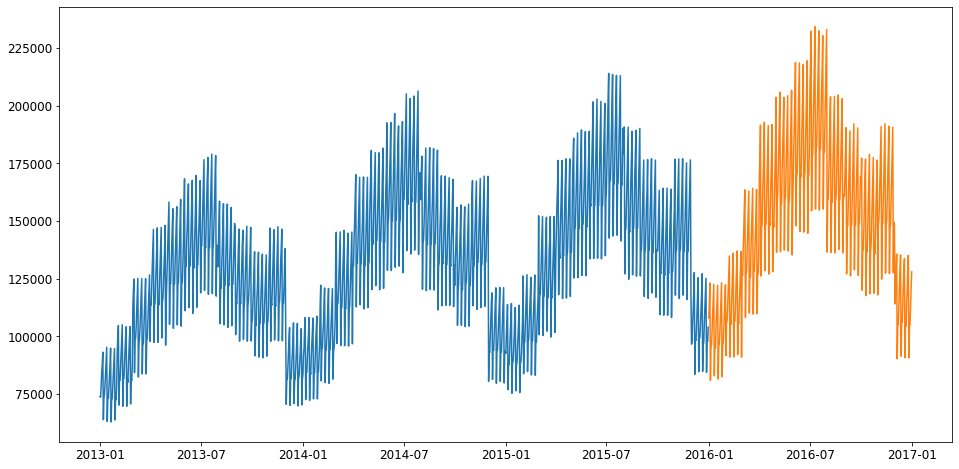

In [11]:
plt.plot(train)
plt.plot(validate)

In [12]:
test.shape

(365, 1)

In [13]:
train["cap"] = 500000
train["floor"] = 0
train.head()

,y,cap,floor
ds,,,
2013-01-01,73844.01,500000,0
2013-01-02,73570.58,500000,0
2013-01-03,78169.48,500000,0
2013-01-04,84467.73,500000,0
2013-01-05,87621.85,500000,0


In [14]:
train = train.reset_index()
validate = validate.reset_index()
test = test.reset_index()

In [15]:
train.head()

,ds,y,cap,floor
0,2013-01-01,73844.01,500000,0
1,2013-01-02,73570.58,500000,0
2,2013-01-03,78169.48,500000,0
3,2013-01-04,84467.73,500000,0
4,2013-01-05,87621.85,500000,0


## Build Model

In [16]:
help(Prophet)

Help on class Prophet in module fbprophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear' or 'logistic' to specify a linear or logistic
 |      trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selected uniformly from
 |      the 

In [17]:
m = Prophet(daily_seasonality=False, growth="logistic", weekly_seasonality="auto", changepoint_range=0.9)
m.add_country_holidays(country_name="US")
m.fit(train)

In [18]:
m.train_holiday_names

0                  New Year's Day
1     Martin Luther King, Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10    Independence Day (Observed)
dtype: object

In [19]:
future = m.make_future_dataframe(periods=len(validate))
future["cap"] = 500000
future["floor"] = 0

In [20]:
future.head()

,ds,cap,floor
0,2013-01-01,500000,0
1,2013-01-02,500000,0
2,2013-01-03,500000,0
3,2013-01-04,500000,0
4,2013-01-05,500000,0


In [21]:
future.tail()

,ds,cap,floor
1456,2016-12-27,500000,0
1457,2016-12-28,500000,0
1458,2016-12-29,500000,0
1459,2016-12-30,500000,0
1460,2016-12-31,500000,0


In [22]:
forecast = m.predict(future)

In [23]:
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,113315.186557,500000,0,61119.899376,75392.041485,113315.186557,113315.186557,0.0,0.0,...,-9914.915845,-9914.915845,-9914.915845,-36689.060138,-36689.060138,-36689.060138,0.0,0.0,0.0,68576.389296
1,2013-01-02,113338.643684,500000,0,59310.614620,73375.707592,113338.643684,113338.643684,0.0,0.0,...,-9798.166456,-9798.166456,-9798.166456,-36736.212199,-36736.212199,-36736.212199,0.0,0.0,0.0,66804.265029
2,2013-01-03,113362.104243,500000,0,67467.927526,81973.667905,113362.104243,113362.104243,0.0,0.0,...,-1656.931547,-1656.931547,-1656.931547,-36816.021139,-36816.021139,-36816.021139,0.0,0.0,0.0,74889.151557
3,2013-01-04,113385.568234,500000,0,76708.424479,90754.582702,113385.568234,113385.568234,0.0,0.0,...,7270.896270,7270.896270,7270.896270,-36923.006146,-36923.006146,-36923.006146,0.0,0.0,0.0,83733.458359
4,2013-01-05,113409.035658,500000,0,85735.950200,99698.068927,113409.035658,113409.035658,0.0,0.0,...,16186.552766,16186.552766,16186.552766,-37050.797579,-37050.797579,-37050.797579,0.0,0.0,0.0,92544.790845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2016-12-27,153750.530117,500000,0,97018.746385,117120.027092,147315.356270,160854.758761,0.0,0.0,...,-9914.915845,-9914.915845,-9914.915845,-37044.146746,-37044.146746,-37044.146746,0.0,0.0,0.0,106791.467526
1457,2016-12-28,153774.730793,500000,0,96969.135476,117322.254600,147311.238131,160918.841440,0.0,0.0,...,-9798.166456,-9798.166456,-9798.166456,-36892.564425,-36892.564425,-36892.564425,0.0,0.0,0.0,107083.999913
1458,2016-12-29,153798.933586,500000,0,105663.914663,126528.928628,147307.120135,160993.915358,0.0,0.0,...,-1656.931547,-1656.931547,-1656.931547,-36780.074612,-36780.074612,-36780.074612,0.0,0.0,0.0,115361.927427
1459,2016-12-30,153823.138496,500000,0,114760.450125,134533.387999,147303.002281,161066.506306,0.0,0.0,...,7270.896270,7270.896270,7270.896270,-36708.770273,-36708.770273,-36708.770273,0.0,0.0,0.0,124385.264494


In [24]:
forecast = pd.concat([forecast, df[:"2016"].reset_index().y], axis=1)
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2013-01-01,113315.186557,500000,0,61119.899376,75392.041485,113315.186557,113315.186557,0.0,0.0,...,-9914.915845,-9914.915845,-36689.060138,-36689.060138,-36689.060138,0.0,0.0,0.0,68576.389296,73844.01
1,2013-01-02,113338.643684,500000,0,59310.614620,73375.707592,113338.643684,113338.643684,0.0,0.0,...,-9798.166456,-9798.166456,-36736.212199,-36736.212199,-36736.212199,0.0,0.0,0.0,66804.265029,73570.58
2,2013-01-03,113362.104243,500000,0,67467.927526,81973.667905,113362.104243,113362.104243,0.0,0.0,...,-1656.931547,-1656.931547,-36816.021139,-36816.021139,-36816.021139,0.0,0.0,0.0,74889.151557,78169.48
3,2013-01-04,113385.568234,500000,0,76708.424479,90754.582702,113385.568234,113385.568234,0.0,0.0,...,7270.896270,7270.896270,-36923.006146,-36923.006146,-36923.006146,0.0,0.0,0.0,83733.458359,84467.73
4,2013-01-05,113409.035658,500000,0,85735.950200,99698.068927,113409.035658,113409.035658,0.0,0.0,...,16186.552766,16186.552766,-37050.797579,-37050.797579,-37050.797579,0.0,0.0,0.0,92544.790845,87621.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2016-12-27,153750.530117,500000,0,97018.746385,117120.027092,147315.356270,160854.758761,0.0,0.0,...,-9914.915845,-9914.915845,-37044.146746,-37044.146746,-37044.146746,0.0,0.0,0.0,106791.467526,103657.89
1457,2016-12-28,153774.730793,500000,0,96969.135476,117322.254600,147311.238131,160918.841440,0.0,0.0,...,-9798.166456,-9798.166456,-36892.564425,-36892.564425,-36892.564425,0.0,0.0,0.0,107083.999913,105313.94
1458,2016-12-29,153798.933586,500000,0,105663.914663,126528.928628,147307.120135,160993.915358,0.0,0.0,...,-1656.931547,-1656.931547,-36780.074612,-36780.074612,-36780.074612,0.0,0.0,0.0,115361.927427,113221.85
1459,2016-12-30,153823.138496,500000,0,114760.450125,134533.387999,147303.002281,161066.506306,0.0,0.0,...,7270.896270,7270.896270,-36708.770273,-36708.770273,-36708.770273,0.0,0.0,0.0,124385.264494,120033.64


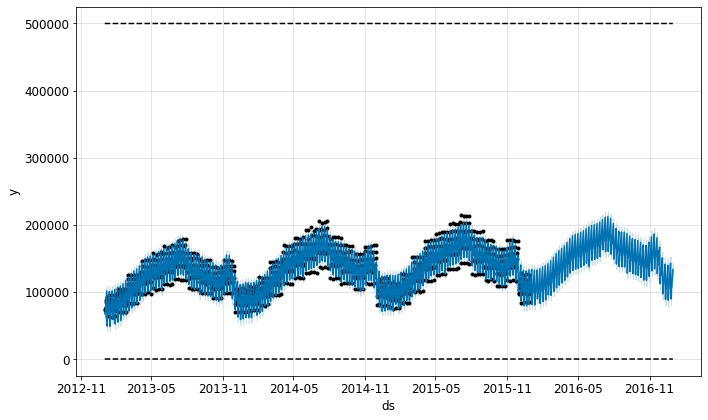

In [25]:
fig1 = m.plot(forecast)

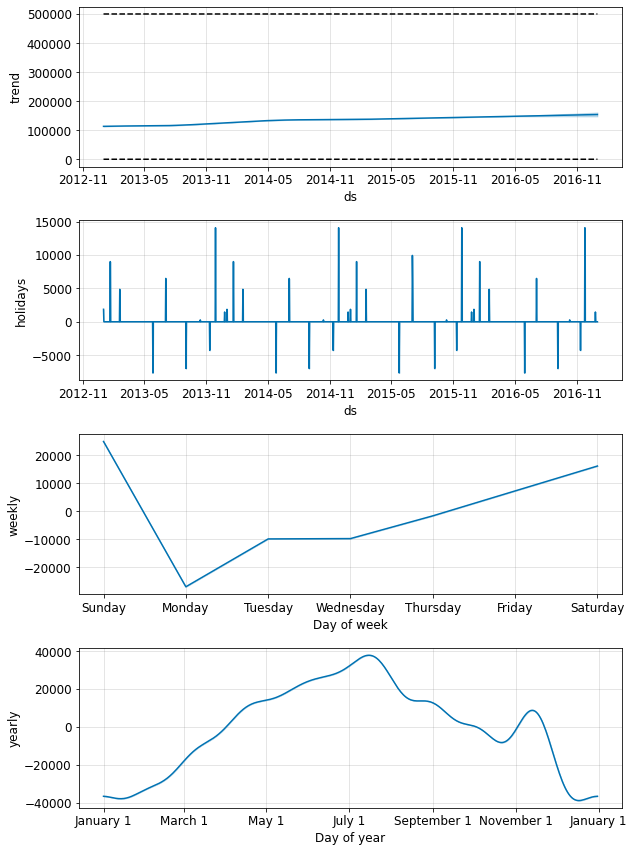

In [26]:
fig2 = m.plot_components(forecast, "holidays")